# Named Entity Recognition and Part Of Speech Tagging

In [1]:
# It is known as token classification task, and is a many to many task.

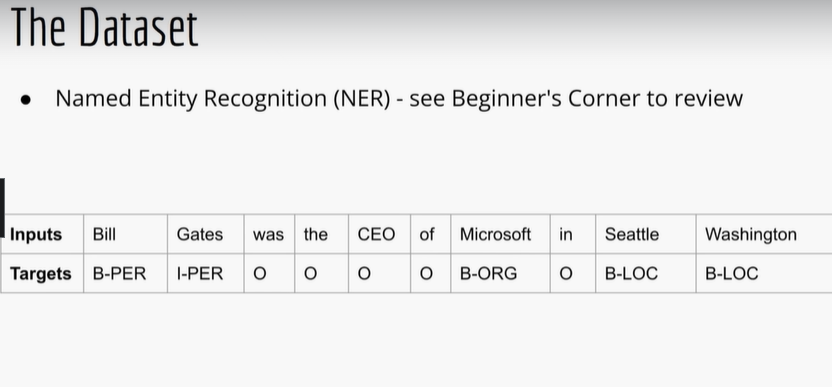

In [2]:
 from datasets import load_dataset

In [3]:
data =load_dataset('conll2003')

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to C:/Users/karan/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
data 

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [5]:
# we can do three different tasks, input sentences are basically in tokens column/

In [20]:
data['train']['tokens'][0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [13]:
# we have to be carefull as our document is already splitted into words 
from transformers import AutoTokenizer
checkpoint='distilbert-base-cased'# faster training

In [14]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

In [26]:
t=tokenizer(data['train']['tokens'][0],is_split_into_words=True)
# we get the words 

In [27]:
t.tokens()# we can see that the word lamb have been converted into subword tokenization.
# therefore we need to deal with it.as we need to take care of teh subword.

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

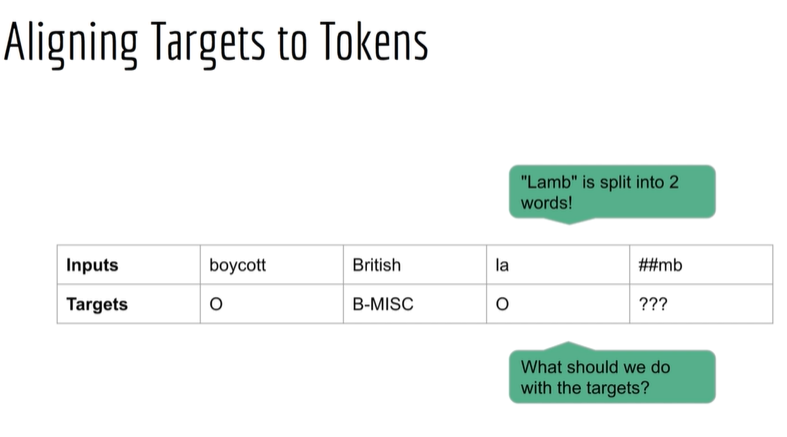

Yes, that's correct. In the example you provided, the word "lamb" has been split into two subword tokens: "la" and "##mb". This is because the tokenizer is using a subword tokenization algorithm that breaks words down into smaller units based on their frequency in the training corpus.

The subword token "la" likely represents a common prefix or substring that occurs in many words in the training corpus, while "##mb" represents the remaining part of the word "lamb". By breaking "lamb" down into two subword tokens, the tokenizer can represent it as a sequence of tokens that are in its vocabulary.

It's worth noting that the specific subword tokens generated by the tokenizer may depend on the specific pre-trained model and the training corpus used to generate the subword vocabulary. Different models and training corpora may result in different subword tokenizations of the same word.

In [25]:
label_names = data['train'].features['ner_tags'].feature.names
# this contains the names of the ,mapped labels we will need it later when we are 
# showing teh data to the end user.

# In the previous section we donot have tp deal with this due to less number of labels that we were 
# using, but this here is the many to many task and we have to be careful while doing this.

In [74]:
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [28]:
# ok to deal with it we will align targets to tokens and we also have to be carefull about the cls and 
# sep tokens as well.
# the huggingface library will tell us to set -100 as the value for the tokens sep and cls so that 
# when we are processing it we can ignore it.

##### Target Alignmnet Example: -

In [58]:
t1=tokenizer([
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'lamb',
 '.'],is_split_into_words=True)

In [72]:
data['train'][0]['ner_tags'] # we see that teh Ner tags are given based of the number of words in the sentence 
# without thinking about the subword splitting criteria.

[3, 0, 7, 0, 0, 0, 7, 0, 0]

In [73]:
t1.word_ids()
# as we see here that instead of 9 tokens we have 12 tokens here to deal with as the 
# cls and sep token gets added in and alongside that we have to deal with the subwords as
# well.

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [66]:
# as the Lamb is splitted up we have the same id's for the lamb word.
t1.tokens()
# and here we can see that the tokens are added, but in our dataset we see that 
# Ner tags have been placed based of the original sentence not the tokenized sentence.
# so we have to take care of this and we see that this is known as Target alignment

['[CLS]',
 'EU',
 'rejects',
 'German',
 'call',
 'to',
 'boycott',
 'British',
 'la',
 '##mb',
 '.',
 '[SEP]']

In [83]:
labels=data['train'][0]['ner_tags'] 
# for this we need to take care of this.

In [87]:
t1.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [79]:
label_names
# Here we need to map the Inside tags as to be equivalent to the Begining tags.
# we deal with this in the above begin2inside functon


['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [90]:
# This function takes care of the labels that we have to deal with.
# We are doing this entirely to map and train our model based of the data and 
# due to tokenizer we have a probelm of subwords and CLS and SEP tags which distrups 
# the final labels in the given dataset.
begin2inside={
    1:2,
    3:4,
    5:6,
    7:8,
}
# It is usefule if we say for example the word German is split into subwords Ger ##Man, then we would like 
# that we get the Ner tags as ger B-MISC and ##Man as I-MISC 
def align_targets(labels,word_ids): # here the labels are the final ner tags in the dataset.
    alligned_labels=[]
    last_word=None # because the first tag will always be equal to the [CLS]
    for word in word_ids: 
        if word is None:
            label=-100 
            # Giving the CLS and SEP tag the -100
        elif word !=last_word: # so that we don't have the same index but 
            label=labels[word] 
            # this takes care of teh new words and map those tokens with their repsective labels from teh dataset
        else:
            label=labels[word]
            if label in begin2inside:
                label=begin2inside[label] 
                # assigning the same index subwords with same the same tag as beofre there
                # 
        alligned_labels.append(label)
        # getiing tyhe new labels 
        last_word = word # we are doing this so that we can compare and move ahead in the listof word_ids
    return alligned_labels

In [91]:
align_targets(labels,t1.word_ids()) # Here we are getting the balanced ner tags from the labels

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]

##### Mapping tokenizers to datasets: -

In [92]:
# Here we will try to recreate the tokenize_fn so that we can map the entire dataset 
def tokenize_fn(batch):
    tokenized_inputs = tokenizer(
        batch['tokens'],truncation=True,is_split_into_words=True
    )
    labels_batch = batch['ner_tags']
    aligned_labels_batch=[]
    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_labels_batch.append(align_targets(labels,word_ids))
    # we need to save the target values to the key called labels
    tokenized_inputs['labels']=aligned_labels_batch
    return tokenized_inputs

In [94]:
tokenized_dataset=data.map(tokenize_fn,batched=True,remove_columns=data['train'].column_names)
# we are just removing the existing columns as they are no longer needed.

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [95]:
tokenized_dataset
# as we will be just making use of ner_tags and the hugging face wants that the output column must be named labels

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [110]:
from transformers import DataCollatorForTokenClassification,AutoModelForTokenClassification

#### Data Collator

In [97]:
# usually we we preprocess the data we need to pad,truncate and torch tensors, but we are not 
# doing this as for the current task we need the above import.
data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer)
# we are just defining our own datacollator.

In [98]:
# this collator object can't process the outputs completely.
tokenized_dataset['train'][:2]

{'input_ids': [[101,
   7270,
   22961,
   1528,
   1840,
   1106,
   21423,
   1418,
   2495,
   12913,
   119,
   102],
  [101, 1943, 14428, 102]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1]],
 'labels': [[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100], [-100, 1, 2, -100]]}

In [102]:
# data_collator(tokenized_dataset['train'][:2]), this willnot work, becuase we need to send a sigle input everytime

[tokenized_dataset['train'][i] for i in range(2)]
# using this we get seprate lists and now we can pass thisin the datacollator to get the required output


[{'input_ids': [101,
   7270,
   22961,
   1528,
   1840,
   1106,
   21423,
   1418,
   2495,
   12913,
   119,
   102],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]},
 {'input_ids': [101, 1943, 14428, 102],
  'attention_mask': [1, 1, 1, 1],
  'labels': [-100, 1, 2, -100]}]

In [104]:
data_collator([tokenized_dataset['train'][i] for i in range(2)])['labels']

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [105]:
# here we can see that we have the tensors format with padding done automatically with -100 value
# -100 value suggest to the model that we donot need these tokens. 

#### METRICS

In [108]:
from datasets import load_metric
import numpy as np

In [107]:
metric= load_metric('seqeval') # we need this because of the output we need to process in this case
# we will be passing a sequence of targets.
# this metrics make use of the batches of the list type not with the simple length based programs.
# this is based on working with string type tags

C:\Users\karan\AppData\Local\Temp\ipykernel_22668\1913547159.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric= load_metric('seqeval') # we need this because of the output we need to process in this case


In [140]:
# so we need the list of list as an input for the logits and the labels that we will get 
# and we need to write the same features.
def compute_metrics(labels_and_logits):
    logits,labels = labels_and_logits
    preds = np.argmax(logits,axis=-1) # we have the predictions as nX t
    str_labels =[[label_names[t] for t in label if t!=-100] for label in labels] # basically remove -100 from the list
    # label_names is defined above which contains all teh labels
    str_preds =[[label_names[p] for p,t in zip(pred,targ) if t !=-100] for pred,targ in zip(preds,labels)]
    the_metrics = metric.compute(predictions=str_preds,references=str_labels)
    return {
        'precision':the_metrics['overall_precision'],
        'recall':the_metrics['overall_recall'],
        'f1':the_metrics['overall_f1'],
        'accuracy':the_metrics['overall_accuracy'],
    }

In [141]:
id2label={k:v for k,v in enumerate(label_names)}
label2id ={v:k for k,v in id2label.items()}
model = AutoModelForTokenClassification.from_pretrained(checkpoint,id2label=id2label,label2id=label2id)
# just setting the labels 

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this 

In [142]:
from transformers import Trainer, TrainingArguments

In [143]:
training_args = TrainingArguments(
    'distilbert-finetuned-ner',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=2, 
    weight_decay=0.01,
    learning_rate=2e-5,


)

In [144]:
trainer= Trainer(
    model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    data_collator=data_collator, # we hvae defined it above to handle the list of batch inputs
    compute_metrics=compute_metrics,# seqeval method is used to calculate the metrics as this is desgned for this type of task
    tokenizer=tokenizer,


)

In [145]:
trainer.train()

C:\Users\karan\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.100800,0.083938,0.896825,0.912824,0.904754,0.976305
2,0.045800,0.073723,0.901390,0.927634,0.914324,0.980367


TrainOutput(global_step=3512, training_loss=0.10428779668138619, metrics={'train_runtime': 2268.821, 'train_samples_per_second': 12.377, 'train_steps_per_second': 1.548, 'total_flos': 307875784051962.0, 'train_loss': 0.10428779668138619, 'epoch': 2.0})

In [149]:
from transformers import pipeline

ner= pipeline('token-classification',model='distilbert-finetuned-ner/checkpoint-3512/',aggregation_strategy="simple")

In [150]:
ner("Bill Gates was the CEO of Microsoft in Seattle, Washington")
# we get good results uisng this.

[{'entity_group': 'PER',
  'score': 0.99892604,
  'word': 'Bill Gates',
  'start': 0,
  'end': 10},
 {'entity_group': 'ORG',
  'score': 0.99491334,
  'word': 'Microsoft',
  'start': 26,
  'end': 35},
 {'entity_group': 'LOC',
  'score': 0.99813545,
  'word': 'Seattle',
  'start': 39,
  'end': 46},
 {'entity_group': 'LOC',
  'score': 0.9976465,
  'word': 'Washington',
  'start': 48,
  'end': 58}]

# POS Tagging

In [151]:
import nltk 
from nltk.corpus import brown

In [152]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\karan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [153]:
corpus = brown.tagged_sents(tagset='universal')

In [202]:
len(corpus[:20000])# we will be converting the code of the JSON

20000

In [221]:
import os
import json 

m = []
for i in corpus:
    tokens = []
    target = []
    for token, tag in i: 
        tokens.append(token)
        target.append(tag)
    j = {'inputs': tokens, 'targets': target}
    s = json.dumps(j)
    
    # Check if file exists
    if os.path.exists('data.json'):
        # If file exists, open in append mode
        with open('data.json', 'a') as f:
            f.write(f"{s}\n")
    else:
        # If file does not exist, open in write mode
        with open('data.json', 'w') as f:
            f.write(f"{s}\n")

In [222]:
data = load_dataset('json',data_files='data.json')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to C:/Users/karan/.cache/huggingface/datasets/json/default-20d9174b1c665886/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [224]:
data # we get the data in the json format 

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets'],
        num_rows: 57340
    })
})

In [225]:
S_data = data['train'].shuffle().select(range(20000))

In [228]:
S_data=S_data.train_test_split()

In [235]:
S_data['train'].features

{'inputs': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'targets': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [230]:
# Right now the targets are basically strings, we need the targets to be of type integr so we will map the 
# targets accordingly.

In [231]:
target_set =set() # we are using set so that we can get the inque targets from the entire dataset

In [236]:
for target in S_data['train']['targets']:
    target_set=target_set.union(target) # way to get all the unique data in the form of a list

In [237]:
target_set # these are the maximumn value for our targets now we need to give them a label so That we can map them accordingly.

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [238]:
target_list = list(target_set)

In [260]:
id2label={k:v for k,v in enumerate(target_list)}
label2id={k:v for v,k in id2label.items()} 

In [244]:
def align_targets(labels,word_ids):
    # we use this function because we need to align the targets in the target section of our data to integers and to take in account 
    # of the subword tokenization and the CLS and SEP tokens
    aligned_labels=[]
    for word in word_ids:
        if word is None:
            label=-100
        else:
            label =label2id[labels[word]]
        aligned_labels.append(label)
    return aligned_labels
# we donot need the same method as before because the subwords will alos get the same value as the main word. we can see that below

In [267]:
labels = S_data['train']['targets'][0]
t= tokenizer(S_data['train']['inputs'][0],is_split_into_words=True)
word_ids=t.word_ids() 
at=align_targets(labels,word_ids) 

In [268]:
aligned_labels = [id2label[i] if i>=0 else None for i in at]
for x,y in zip(t.tokens(),aligned_labels):
    print(f'{x}\t{y}')
# we can see here how the subwords are bieng handled here.

[CLS]	None
Sergei	NOUN
V	NOUN
##ik	NOUN
##ulo	NOUN
##v	NOUN
,	.
as	ADP
the	DET
lone	ADJ
male	NOUN
,	.
meets	VERB
the	DET
competition	NOUN
well	ADV
with	ADP
some	DET
brilliant	ADJ
hits	NOUN
,	.
but	CONJ
the	DET
work	NOUN
is	VERB
designed	VERB
to	PRT
belong	VERB
to	ADP
the	DET
ladies	NOUN
.	.
[SEP]	None


In [269]:
def tokenize_fn(batch):
    tokenized_inputs = tokenizer(batch['inputs'],truncation=True,is_split_into_words=True)
    # we use truncation = True so that the words in the sentences above a specified max_length sequence will be ignored.
    labels_batch = batch['targets']
    aligned_labels_batch =[]
    for i, labels in enumerate(labels_batch):
        word_ids=tokenized_inputs.word_ids(i)
        aligned_labels_batch.append(align_targets(labels,word_ids))
    tokenized_inputs['labels']=aligned_labels_batch
    return tokenized_inputs

In [271]:
tokenized_dataset=S_data.map(tokenize_fn,batched=True,remove_columns=S_data['train'].column_names)# because we donot need the same columns.

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [272]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})

In [273]:
data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer)
# we need this doatacollator for processing tokens type of text classification tasks

In [275]:
# we need to preprocess the data for calculation of metrics where in the above we used the seqeval modeule whereas we donot have 
# the same thing for this task as the above task was based on IOB format.

In [277]:
def flatten(list_of_lists):
    flattened = [val for sublist in list_of_lists for val in sublist]
    return flattened
# we are flatting the lists here so that we can compare the outputs 

In [294]:
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(logist_and_labels):
    logits,labels=logist_and_labels
    preds = np.argmax(logits,axis=-1)
    updated_labels = [[t for t in label if t !=-100] for label in labels]
    updated_preds = [[p for p,t in zip(ps,ts) if t !=-100] for ps,ts in zip(preds,labels)] # so there is a chance that predictions 
    # may get -100 as something else therefore we remove the -100 by comparing from the labels
    labels_flat = flatten(updated_labels)
    preds_flat= flatten(updated_preds)
    acc = accuracy_score(labels_flat,preds_flat)
    f1 = f1_score(labels_flat,preds_flat,average='macro')
    return {
        'f1':f1,
        'acc':acc,
    }
# I ve written a test program below as well.

In [288]:
labels = [[-100,0,0,1,2,1,-100]]
logits = np.array([[
    [0.8,0.1,0.1],
    [0.8,0.1,0.1],
    [0.8,0.1,0.1],
    [0.1,0.7,0.2],
    [0.1,0.7,0.2],
    [0.1,0.7,0.8],
    [0.1,0.7,0.2],
]])
compute_metrics((logits,labels))
# we can see that we have the required, we baiscally ignore the -100 based logist and we can see the last two list of lists to 
# see that we are getting the required output.

[[0 0 0 1 1 2 1]]
[[0, 0, 1, 2, 1]]
[[0, 0, 1, 1, 2]]


{'f1': 0.5, 'acc': 0.6}

In [290]:
model = AutoModelForTokenClassification.from_pretrained(checkpoint,id2label=id2label,label2id=label2id)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this 

In [297]:
training_args1= TrainingArguments(
    'ner',
    evaluation_strategy='epoch',
    num_train_epochs=1,
    save_strategy='epoch',
)
# I am training it for only 1 epoch as it takes a lot of time to train on the PC

In [298]:
trainer3= Trainer(
    model,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    args=training_args1,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [299]:
trainer3.train()

C:\Users\karan\.pyenv\pyenv-win\versions\3.11.3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Acc
1,0.064800,0.055687,0.937300,0.983149


TrainOutput(global_step=1875, training_loss=0.09069466756184896, metrics={'train_runtime': 1104.2621, 'train_samples_per_second': 13.584, 'train_steps_per_second': 1.698, 'total_flos': 194299953569280.0, 'train_loss': 0.09069466756184896, 'epoch': 1.0})

In [301]:
pipe2 = pipeline('token-classification',model= 'ner/checkpoint-1875/')

In [302]:
pipe2("Bill Gates was the CEO of Microsoft in Seattle, Washington")
# therefore we get the output from the model given by fine tuninng the model

[{'entity': 'NOUN',
  'score': 0.99862516,
  'index': 1,
  'word': 'Bill',
  'start': 0,
  'end': 4},
 {'entity': 'NOUN',
  'score': 0.9985784,
  'index': 2,
  'word': 'Gates',
  'start': 5,
  'end': 10},
 {'entity': 'VERB',
  'score': 0.9995555,
  'index': 3,
  'word': 'was',
  'start': 11,
  'end': 14},
 {'entity': 'DET',
  'score': 0.999785,
  'index': 4,
  'word': 'the',
  'start': 15,
  'end': 18},
 {'entity': 'NOUN',
  'score': 0.9987245,
  'index': 5,
  'word': 'CEO',
  'start': 19,
  'end': 22},
 {'entity': 'ADP',
  'score': 0.9995315,
  'index': 6,
  'word': 'of',
  'start': 23,
  'end': 25},
 {'entity': 'NOUN',
  'score': 0.9990866,
  'index': 7,
  'word': 'Microsoft',
  'start': 26,
  'end': 35},
 {'entity': 'ADP',
  'score': 0.99939394,
  'index': 8,
  'word': 'in',
  'start': 36,
  'end': 38},
 {'entity': 'NOUN',
  'score': 0.9992748,
  'index': 9,
  'word': 'Seattle',
  'start': 39,
  'end': 46},
 {'entity': '.',
  'score': 0.9998085,
  'index': 10,
  'word': ',',
  'star